<a href="https://colab.research.google.com/github/pasticeta-hub/Investigaci-n-de-operaciones/blob/main/Inventario%20con%20descuento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventario con descuento

En esta notebook resolvemos un problema de inventario con descuento por cantidad usando el modelo de lote económico de pedido (EOQ) y un punto de descuento en el precio.


In [31]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

## Importamos las librerías a utilizar

Primero cargamos `numpy`, `sympy` y `matplotlib`, que vamos a usar para hacer los cálculos y las gráficas.


In [32]:
c1 = 3.0          # precio normal
c2 = 2.5          # precio con descuento
d  = 150 * 1.25   # demanda diaria de galones
h  = 0.02         # costo de mantener inventario
K  = 20.0         # costo por pedido
L  = 2.0          # tiempo de entrega (dias)
q  = 1000.0       # punto de descuento

## Ejemplo

LubeCar se especializa en cambios rápidos de aceite para motor de automóvil. El servicio compra aceite para motor a granel, a 3 por galón. Si LubeCar compra más de 100 galones, obtiene un descuento de 2.50 por galón. En el servicio se atienden unos 150 autos diarios, y cada cambio de aceite requiere de 1.25 galones. LubeCar guarda el aceite a granel con un costo de 0.02 por galón y por día. También, el costo de colocar un pedido de aceite a granel es de $20. Hay un tiempo de 2 días para la entrega. Determine la política óptima de inventario.

In [33]:
def eoq(K, d, h):
    Q = np.sqrt(2 * K * d / h)
    return float(Q)

def costo_total(Q, c, d, K, h):
    Q = np.asarray(Q, dtype=float)
    return c * d + (K * d) / Q + (h * Q) / 2


### Paso 1. Funciones de costo y EOQ sin descuento

Aqui definimos la cantidad economica de pedido sin tomar en cuenta el descuento y la funcion de costo total anual \(T(Q)\). Estas funciones nos sirven como base para todo lo demas.


In [34]:
def calcular_Q1(c1, c2, d, K, h, Q0):
    Q = sp.symbols('Q', positive=True)

    T_Q0 = c1 * d + (K * d) / Q0 + (h * Q0) / 2

    ecuacion = sp.Eq(
        Q**2 + (2 / h) * (c2 * d - T_Q0) * Q + (2 * K * d) / h,
        0
    )

    soluciones = sp.solve(ecuacion, Q)
    soluciones_reales = [s for s in soluciones if s.is_real]

    Q1 = max(soluciones_reales)
    return float(Q1)


### Paso 2. Calculo de \(Q_1\) con **sympy**

En esta parte planteamos la ecuacion cuadratica que sale de igualar el costo sin descuento con el costo usando el precio con descuento.  
Con `sympy` resolvemos la ecuacion y elegimos la raiz positiva mas grande, que es el valor de \(Q_1\).


In [40]:
def Q_optima_y_region(c1, c2, d, K, h, q):
    Q0 = eoq(K, d, h)
    Q1 = calcular_Q1(c1, c2, d, K, h, Q0)

    if Q0 < q < Q1:
        Q_star = q
        region = "II"
    else:
        Q_star = Q0
        region = "I" if Q0 <= q else "II"

    return Q0, Q1, Q_star, region


### Paso 3. Funcion que decide \(Q^*\) y en que region esta

Usando \(Q_0\) (EOQ sin descuento), \(q\) (punto de descuento) y \(Q_1\), revisamos en que zona queda el valor optimo.  
Si se cumple \(Q_0 < q < Q_1\), conviene pedir justo \(q\) (region II).  
En otro caso usamos \(Q_0\) como cantidad optima (region I o II segun el caso).


In [41]:
Q0, Q1, Q_star, region = Q_optima_y_region(c1, c2, d, K, h, q)

print("Q eoq sin descuento:", Q0)
print("Q1:", Q1)
print("Q optima:", Q_star)
print("Region:", region)


Q eoq sin descuento: 612.3724356957945
Q1: 10564.247786546852
Q optima: 1000.0
Region: II


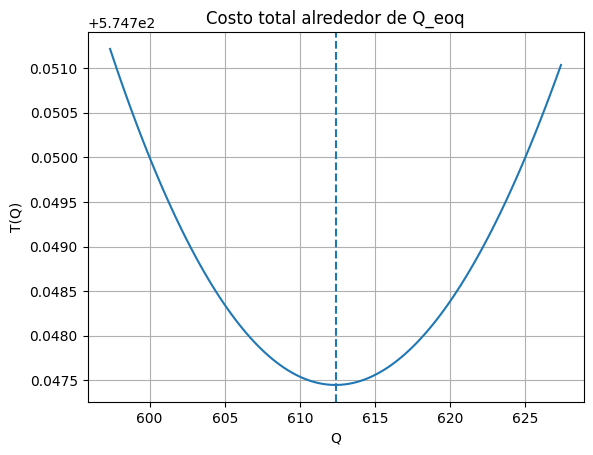

In [42]:
Q0, Q1, Q_star, region = Q_optima_y_region(c1, c2, d, K, h, q)

x_min = Q0 - 15
x_max = Q0 + 15

xs = np.linspace(x_min, x_max, 120)
cs = np.where(xs < q, c1, c2)
Ts = costo_total(xs, cs, d, K, h)

plt.plot(xs, Ts)
plt.axvline(Q0, linestyle="--")
plt.xlabel("Q")
plt.ylabel("T(Q)")
plt.title("Costo total alrededor de Q_eoq")
plt.grid(True)
plt.show()


### Paso 4. Grafica del costo alrededor de \(Q_0\)

Aqui dibujamos el costo total \(T(Q)\) en un intervalo pequeno alrededor de \(Q_0\).  
La idea es visualizar que el costo tiene forma de parabola y que el minimo se alcanza cerca de \(Q_0\).


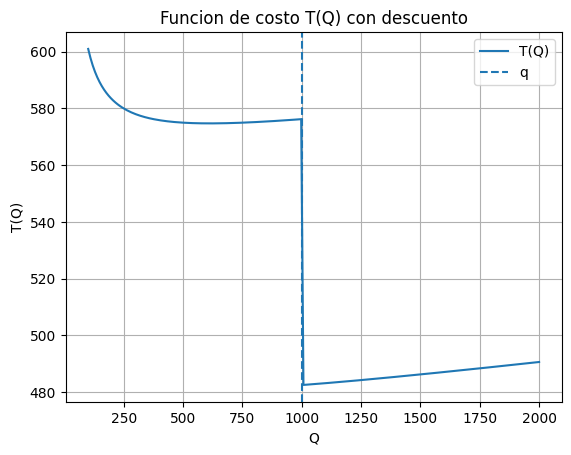

In [53]:
def T_con_descuento(Q, c1, c2, d, K, h, q):
    Q = np.asarray(Q, dtype=float)
    c = np.where(Q < q, c1, c2)
    return c * d + (K * d) / Q + (h * Q) / 2

Q_vals = np.linspace(100, 2000, 200)
T_vals = T_con_descuento(Q_vals, c1, c2, d, K, h, q)

plt.plot(Q_vals, T_vals, label="T(Q)")
plt.axvline(q, linestyle="--", label="q")
plt.xlabel("Q")
plt.ylabel("T(Q)")
plt.title("Funcion de costo T(Q) con descuento")
plt.legend()
plt.grid(True)
plt.show()


### Paso 5. Funcion por tramos \(T(Q)\) con descuento

Definimos una funcion que cambia el costo unitario dependiendo de si \(Q\) es menor o mayor que \(q\).  
Luego graficamos \(T(Q)\) en un rango mas grande de cantidades y marcamos el punto \(q\) para ver donde cambia el precio.


In [54]:
def tiempos_politica(Q_star, d, L):
    t_ef = Q_star / d
    n_pedidos = int(np.floor(L / t_ef))
    L_rest = L - n_pedidos * t_ef
    punto_reorden = np.ceil(L_rest * d)
    return t_ef, n_pedidos, L_rest, punto_reorden


### Paso 6. Calculo de tiempos y punto de reorden

Con la cantidad optima \(Q^*\) calculamos:
- el tiempo de ciclo efectivo \(t = Q^* / d\),
- cuantas ordenes entran durante el tiempo de entrega \(L\),
- el tiempo de retraso restante,
- y el punto de reorden \(R\), que es el nivel de inventario al que se lanza un nuevo pedido.


In [66]:
def resumen_inventario(c1, c2, d, K, h, L, q):
    Q0, Q1, Q_star, region = Q_optima_y_region(c1, c2, d, K, h, q)

    if Q_star < q:
        c_usar = c1
    else:
        c_usar = c2

    T_Q0 = costo_total(Q0, c1, d, K, h)
    T_Q_star = costo_total(Q_star, c_usar, d, K, h)

    t_ef, n_pedidos, L_rest, R = tiempos_politica(Q_star, d, L)

    print("Inventario con descuento")
    print("-----------------------")
    print("Q eoq sin descuento:", Q0)
    print("T(Q eoq):", T_Q0)
    print("Q1:", Q1)
    print("Region optima:", region)
    print("Q optima:", Q_star)
    print("T(Q*):", T_Q_star)
    print()
    print("Tiempo de retraso efectivo:", t_ef)
    print("Numero de pedidos:", n_pedidos)
    print("Tiempo de retraso restante:", L_rest)
    print()
    print("Politica de inventario:")
    print("Pedir", Q_star, "cuando el inventario caiga a:", R)


### Paso 7. Funcion con el resumen de la politica de inventario

Esta funcion junta todo: calcula \(Q^*\), la region, el costo minimo, los tiempos y el punto de reorden.  
Al final imprime la informacion importante para describir la politica optima de inventario de LubeCar.


In [70]:
def politica_sola(c1, c2, d, K, h, L, q):
    Q0, Q1, Q_star, region = Q_optima_y_region(c1, c2, d, K, h, q)
    t_ef, n_pedidos, L_rest, R = tiempos_politica(Q_star, d, L)

    print("Solo la politica de inventario")
    print("Pedir", Q_star, "cuando el inventario caiga a:", R)


Inventario con descuento
-----------------------
Q eoq sin descuento: 346.41016151377545
T(Q eoq): 107.32050807568876
Q1: 346.4101668625769
Region optima: II
Q optima: 346.41016151377545
T(Q*): 107.32050807568876

Tiempo de retraso efectivo: 11.547005383792515
Numero de pedidos: 2
Tiempo de retraso restante: 6.905989232414971

Politica de inventario:
Pedir 346.41016151377545 cuando el inventario caiga a: 208.0


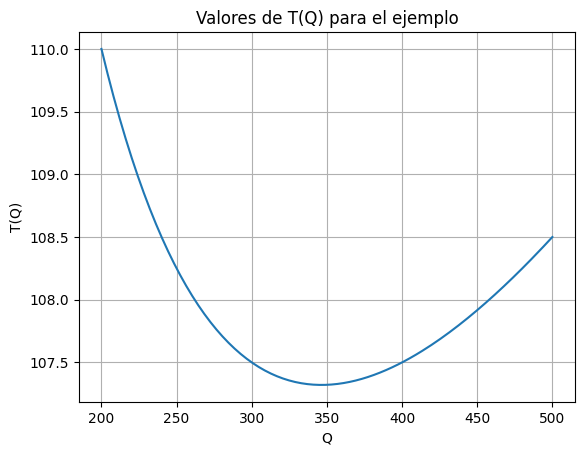

In [75]:
c1_2 = 3.0
c2_2 = 3
d_2  = 30.0
h_2  = 0.05
K_2  = 100.0
L_2  = 30.0
q_2  = 300.0

resumen_inventario(c1_2, c2_2, d_2, K_2, h_2, L_2, q_2)

Q_vals_2 = np.linspace(200, 500, 150)
T_vals_2 = T_con_descuento(Q_vals_2, c1_2, c2_2, d_2, K_2, h_2, q_2)

plt.plot(Q_vals_2, T_vals_2)
plt.xlabel("Q")
plt.ylabel("T(Q)")
plt.title("Valores de T(Q) para el ejemplo")
plt.grid(True)
plt.show()
